In [420]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [1]:
import tensorflow as tf

In [5]:
#tf.test.is_gpu_available()

## Travel time prediction

In [421]:
data = pd.read_csv('../dataPreprocessing/data/data.csv', low_memory=False)

In [422]:
data.rename({'TripID':'sequence_id'}, axis=1, inplace=True)

In [423]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1899557 entries, 0 to 1899556
Data columns (total 26 columns):
 #   Column             Dtype  
---  ------             -----  
 0   vehicle_id         int64  
 1   line_id            int64  
 2   arrival_time       object 
 3   departure_time     object 
 4   station_id         int64  
 5   vehicle_type       float64
 6   stop_time          float64
 7   sequence_id        object 
 8   order              int64  
 9   line_label         object 
 10  travel_time        float64
 11  outlier            int64  
 12  hour               int64  
 13  quarter            int64  
 14  weekday            int64  
 15  service_class      int64  
 16  datetime           object 
 17  Temperature        float64
 18  Precipitation      float64
 19  Wind Speed         float64
 20  Visibility         float64
 21  Cloud Cover        float64
 22  Relative Humidity  float64
 23  Conditions         float64
 24  distance_diff      int64  
 25  distance_traveled 

In [424]:
#feature engineering : add is_terminal feature
stops = pd.read_csv('../dataPreprocessing/data/stations_paths.csv')

In [425]:
terminals = stops[['station_id','order']].query('order == 1').station_id.values
terminals

array([  1,  14,  15,  43,  13,  67,  69,  71,  72,  89,  14, 103,  69,
       115,  69, 126, 127, 147, 161, 175, 161, 161, 211, 204,  15, 237,
       127, 246, 127, 204, 253, 237, 159, 161, 264, 161, 226, 161, 267,
       161, 276, 260,  15,  15, 269], dtype=int64)

In [426]:
data['is_terminal'] = data.station_id.apply(lambda x : 1 if x in terminals else 0)

In [428]:
data['travel_time'] = data.groupby('sequence_id').travel_time.shift()

In [429]:
data = data[data.is_terminal == 1]
data.shape

(231454, 27)

In [430]:
#split data
data.datetime = data.datetime.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H'))
data = data.sort_values(['datetime','sequence_id'])
data['month'] = data.datetime.dt.month
data['year'] = data.datetime.dt.year
data['minute'] = data.datetime.dt.minute

In [431]:
#fillna
data.fillna(-1, inplace=True)

In [432]:
data = data.reset_index(drop=True)

<AxesSubplot:xlabel='station_id', ylabel='stop_time'>

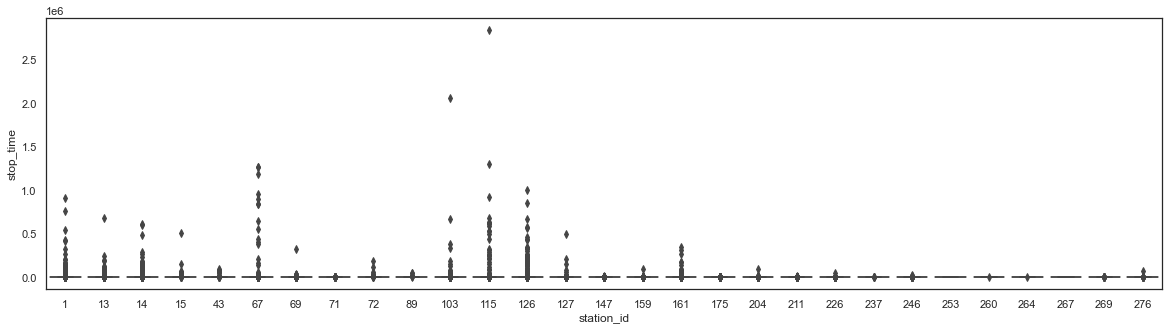

In [433]:
import seaborn as sns

plt.figure(figsize = (20,5))
sns.boxplot(data = data, x='station_id', y='stop_time')

In [434]:
#target box plot
#data = data[data.stop_time < 1800]
#data.stop_time.plot(kind = 'box')

In [435]:
#select range of datetimes between min (th = 30 secs) and (Q3 + (Q3-Q1)*3)   
#in max_range = Q3 + (Q3-Q1)*3, I chose 2.4 and not 1.4 because I don't want to remove a lot of outliers
#sometimes huge delays occurs, there mut be a reason why that happens and both the graph and models need to be prepared
#for such delays

line_station_range = data.dropna().groupby(['station_id'],as_index=True).stop_time.describe()
EIQ = line_station_range['75%'] - line_station_range['25%']
line_station_range['max_range'] = line_station_range['75%'] +  EIQ*1.4
line_station_range = line_station_range['max_range'].reset_index()

In [436]:
line_station_range = dict( (station, max_range) for station, max_range in line_station_range.values)

In [437]:
def drop_outlier(*record):
    stop_time = record[0]
    station_id = record[1]    
    max_range = line_station_range[station_id]
    
    if stop_time > max_range :
        return True
    
    return False

In [438]:
data = data[data.stop_time != 0]

In [439]:
mask_drop = data[['stop_time','station_id']].apply(lambda x : drop_outlier(*x), axis=1 )
mask_drop.value_counts()

False    200485
True      24741
dtype: int64

In [440]:
data['outlier'] = data[['stop_time', 'station_id']].apply(lambda x : 1 if drop_outlier(*x) else 0 , axis=1 )

<AxesSubplot:xlabel='station_id', ylabel='stop_time'>

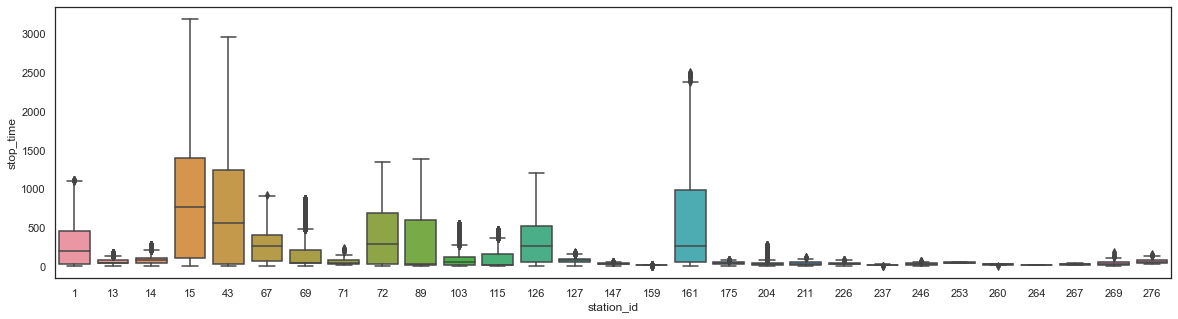

In [441]:
plt.figure(figsize = (20,5))
sns.boxplot(data = data[data.outlier == 0], x='station_id', y='stop_time')

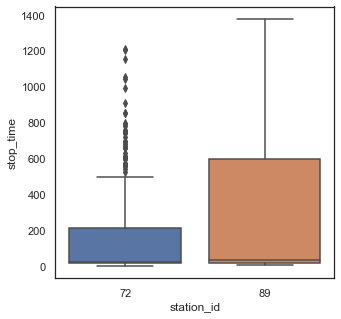

In [442]:
plt.figure(figsize = (5,5))
sns.boxplot(data = data[data.outlier == 0].query('line_id == 11'), x='station_id', y='stop_time')
plt.show()

In [443]:
data = data[data.outlier == 0]
data.shape

(200485, 30)

## GRU : n time step window + Keras tuner + Timeseries crossvalidation

In [444]:
#thabet ki taya7t l outliers 9assit sequence walé : doing
#add Time series cross validation : done
#try autoEncoders : maybe
#keras tuner : done
#model stacking, ensembling : maybe (combination of keras tuner best models)
#different timesteps : done

In [445]:
from kerastuner import RandomSearch , Hyperband , BayesianOptimization
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.data import Dataset
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.losses import MAE, MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

In [446]:
generate_timesteps = True
train_model = False

### Generate timesteps and target

In [555]:
selcted_features = ['sequence_id','arrival_time','service_class','year','weekday','hour','month','line_id','station_id','vehicle_type','vehicle_id','stop_time']
len(selcted_features)

12

In [556]:
data[selcted_features]

,sequence_id,arrival_time,service_class,year,weekday,hour,month,line_id,station_id,vehicle_type,vehicle_id,stop_time
0,17_126,2020-02-17 14:35:58,0,2020,0,14,2,17,126,2.0,48,242.0
1,1_13,2020-02-17 14:36:40,0,2020,0,14,2,1,13,2.0,154,34.0
2,3_13,2020-02-17 14:37:01,0,2020,0,14,2,3,13,2.0,202,41.0
3,8_69,2020-02-17 14:37:20,0,2020,0,14,2,8,69,2.0,156,107.0
4,12_13,2020-02-17 14:37:23,0,2020,0,14,2,12,13,2.0,204,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...
200441,3_13,2021-01-12 12:55:52,0,2021,1,12,1,3,13,2.0,84,41.0
200442,12_103,2021-01-12 12:59:54,0,2021,1,12,1,12,103,2.0,213,70.0
200443,16_126,2021-01-12 13:10:10,0,2021,1,13,1,16,126,2.0,56,448.0
200444,13_103,2021-01-12 13:12:21,0,2021,1,13,1,13,103,2.0,213,11.0


In [557]:
data = data.sort_values(['line_id', 'station_id' ,'arrival_time'])
data['sequence_id'] = data.line_id.astype(str)+'_'+data.station_id.astype(str)
selcted_features.remove('year')
selcted_features.remove('arrival_time')
data.head()

,vehicle_id,line_id,arrival_time,departure_time,station_id,vehicle_type,stop_time,sequence_id,order,line_label,...,Relative Humidity,Conditions,distance_diff,distance_traveled,is_terminal,month,year,minute,cumean_stoptime,nbTrip
14,85,1,2020-02-17 14:41:20,2020-02-17 14:41:54,1,2.0,34.0,1_1,1,5,...,42.59,2.0,0,0,1,2,2020,0,-1.000000,0
15,68,1,2020-02-17 14:42:16,2020-02-17 14:51:46,1,2.0,570.0,1_1,1,5,...,42.59,2.0,0,0,1,2,2020,0,34.000000,1
27,186,1,2020-02-17 14:47:03,2020-02-17 14:56:28,1,2.0,565.0,1_1,1,5,...,42.59,2.0,0,0,1,2,2020,0,302.000000,2
42,210,1,2020-02-17 14:56:11,2020-02-17 14:56:36,1,2.0,25.0,1_1,1,5,...,42.59,2.0,0,0,1,2,2020,0,389.666667,3
100,125,1,2020-02-17 15:40:53,2020-02-17 15:44:15,1,2.0,202.0,1_1,1,5,...,39.70,2.0,0,0,1,2,2020,0,298.500000,4


In [558]:
data[selcted_features].shape

(200446, 10)

In [559]:
mask = data.groupby('sequence_id').line_id.count() > 5
selected_sequences = data.groupby('sequence_id').line_id.count()[mask].index.values
data = data[data.sequence_id.isin(selected_sequences)]

In [561]:
#groupby sequence_id add cummulative lag target mean and std
#data.arrival_time = data.arrival_time.apply(lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

data['cumean_stoptime']=data.groupby('sequence_id').stop_time.apply(lambda x: x.shift(1).expanding().mean())
selcted_features.append('cumean_stoptime')
data = data.fillna(-1)

<AxesSubplot:>

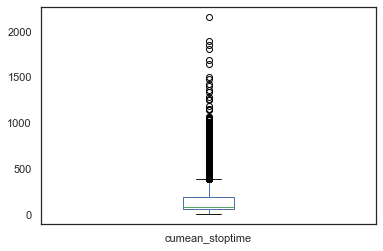

In [563]:
data[selcted_features].cumean_stoptime.plot(kind='box')

In [564]:
selcted_features = list(set(selcted_features))

In [565]:
data = data.sort_values('arrival_time')
data = data.reset_index(drop=True)
data[selcted_features].shape

(200446, 11)

In [566]:
data[selcted_features].isnull().sum()

line_id            0
hour               0
vehicle_id         0
service_class      0
weekday            0
cumean_stoptime    0
sequence_id        0
stop_time          0
station_id         0
vehicle_type       0
month              0
dtype: int64

<AxesSubplot:>

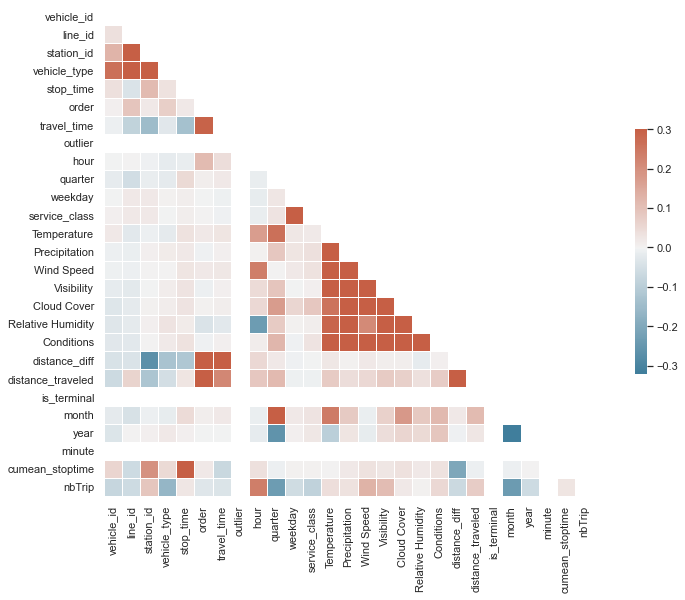

In [567]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [579]:
data[selcted_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200446 entries, 0 to 200445
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   line_id          200446 non-null  int64  
 1   hour             200446 non-null  int64  
 2   vehicle_id       200446 non-null  int64  
 3   service_class    200446 non-null  int64  
 4   weekday          200446 non-null  int64  
 5   cumean_stoptime  200446 non-null  float64
 6   sequence_id      200446 non-null  object 
 7   stop_time        200446 non-null  float64
 8   station_id       200446 non-null  int64  
 9   vehicle_type     200446 non-null  float64
 10  month            200446 non-null  int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 16.8+ MB


In [580]:
data = data.fillna(-1)

In [581]:
import joblib

scaler_filename = "models/stoptime/encoder.save"
joblib.dump(scaler, scaler_filename) 

['models/stoptime/encoder.save']

In [583]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tqdm import tqdm
import copy
import joblib

if generate_timesteps:

    #extract target
    tmp_data = data.stop_time.values
    np.save('stopTime_steps/target/target.npy', tmp_data)

    
    #extract time step features extraction
    #datetime lag features
    tmp_data = data[selcted_features]
    tmp_data['stop_time_lag'] = tmp_data[['sequence_id', 'stop_time']].groupby('sequence_id',dropna=False).shift(1)

    #drop target and sequence_id
    tmp_data.drop(['stop_time','sequence_id'], axis=1, inplace=True)
    
    #scale
    tmp_data.fillna(-1, inplace=True)
    scaler = MinMaxScaler()
    scaler.fit(tmp_data)
    scaler_filename = "models/stoptime/scaler.save"
    joblib.dump(scaler, scaler_filename) 

    max_timesteps = 5
    for timestep in tqdm(range(max_timesteps)):
        if timestep == 0 :
            #scale and extract data 
            tmp_data = scaler.transform(tmp_data)
            tmp_data = tmp_data.reshape(-1, 1, 10)
            np.save('stopTime_steps/features/timestep{}.npy'.format(max_timesteps), tmp_data)
        else:
            #previous time step
            tmp_data = data[selcted_features].groupby('sequence_id',dropna=False).shift(timestep)
            tmp_data['stop_time_lag'] = data[['sequence_id', 'stop_time']].groupby('sequence_id',dropna=False).shift(timestep+1)

            #scale and extract data
            tmp_data.drop(['stop_time'], axis=1, inplace=True)
            tmp_data.fillna(-1, inplace=True)
            tmp_data = scaler.transform(tmp_data)
            tmp_data = tmp_data.reshape(-1, 1, 10)
            np.save('stopTime_steps/features/timestep{}.npy'.format(max_timesteps-timestep), tmp_data)

100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


In [584]:
#model architecture keras API

def generate_model(hp=None):
    #default hyper parameters
    num_stacked_gru   = 0
    num_stacked_dense = 3
    droput_rate       = 0.394399
    gru_units         = 128
    dense_units       = 256
    learning_rate     = 0.001236
    timestep          = 5
    leakyRelu_alpha   = 0.088840
    dims              = 10
    
    if hp:
        num_stacked_gru   = hp.Choice('num_stacked_gru', values=[0, 1])
        num_stacked_dense = hp.Choice('num_stacked_dense', values=[1, 2, 3, 4])
        droput_rate       = hp.Float('droput_rate', min_value=0.1 , max_value=0.5)
        learning_rate     = hp.Float('learning_rate', min_value=0.001, max_value=0.01)
        gru_units         = hp.Int('gru_units', min_value=64, max_value=256, step=32)
        dense_units       = hp.Int('dense_units', min_value=128, max_value=256, step=32)
        timestep          = hp.Int('time_step', min_value=3, max_value=5, step=1)
        leakyRelu_alpha   = hp.Float('leakyRelu_alpha', min_value=0, max_value=0.3)
        
    #time step inputs
    input_layers = []
    for i in range(timestep):
        input_layers.append(layers.Input(shape = (1,dims)))
    if timestep > 1 :
        x = layers.concatenate(input_layers, axis = 1)
    else:
        x = input_layers[0]
    

    #GRU layers Block
    if num_stacked_gru > 0 :
        x = layers.GRU(units=gru_units, activation='tanh' , input_shape=(-1, timestep, dims), return_sequences=True )(x)
        for i in range(num_stacked_gru):
            if i+1 == num_stacked_gru:
                x = layers.GRU(units=gru_units, activation='tanh', return_sequences=False )(x)
            else:
                x = layers.GRU(units=gru_units, activation='tanh', return_sequences=True )(x)
    else : 
        x = layers.GRU(units=gru_units, activation='tanh' , input_shape=(-1, timestep, dims), return_sequences=False )(x)
    
    #Dense layers block
    for i in range(num_stacked_dense):
        x = layers.Dense(dense_units, activation='linear')(x)
        x = layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x, leakyRelu_alpha)
        x = layers.Dropout(droput_rate)(x)
    out = layers.Dense(1, activation='relu')(x)
    
    #build model
    model = Model(input_layers, out)
    
    #model compilation
    optimizer = Adam(lr=learning_rate)
    loss = MeanSquaredError()
    #metrics = tfa.metrics.RSquare()
    metrics = tf.keras.metrics.RootMeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

In [585]:
model = generate_model()
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_111 (InputLayer)          [(None, 1, 10)]      0                                            
__________________________________________________________________________________________________
input_112 (InputLayer)          [(None, 1, 10)]      0                                            
__________________________________________________________________________________________________
input_113 (InputLayer)          [(None, 1, 10)]      0                                            
__________________________________________________________________________________________________
input_114 (InputLayer)          [(None, 1, 10)]      0                                            
___________________________________________________________________________________________

In [501]:
#time series cross validation splits by year quarters
def timeseries_yaerMonthSplit(data, cv_skipMonths):
    yearMonths = data[['year','month']].drop_duplicates().values
    splits = []
    split = []
    for yearM in yearMonths:
        split += list(data[(data.year == yearM[0])&(data.month == yearM[1])].index)
        cv_skipMonths -= 1
        if cv_skipMonths < 0:
            splits.append(split)
            split = [] 
    
    return splits

In [ ]:
import functools
import kerastuner as kt
import operator
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

class CVTuner(kt.engine.tuner.Tuner):
    
    #run trial override
    def run_trial(self, trial, X, y, splits, epochs=1, callbacks=None, purged=False, batch_size=512):
        
        val_losses = []        
        nb_cv = len(splits)
        
        #Trial n timestep hyper parameter
        time_step = trial.hyperparameters['time_step']
        
        if time_step > 1 :
            X = X[-time_step:]
        else:
            X = X[-1]
            
        for k_iter in range(nb_cv-1):
            print('')
            print('------Time--Series--CrossValidation--iteration--N°{}------'.format(k_iter+1), end='\n\n')
            #time series cross-validation split
            if purged :
                train_idx = splits[k_iter]
            else : 
                train_idx = functools.reduce(operator.iconcat, splits[:k_iter+1], [])
                
            if time_step > 1 :
                X_train = []
                X_val   = []
                for i in range(time_step):
                    X_train.append(X[i][train_idx])
                    X_val.append( X[i][splits[k_iter+1]])
            else:
                X_train , X_val= X[train_idx], X[splits[k_iter+1]]

            y_train, y_val = y[train_idx], y[splits[k_iter+1]]
            
            #tensorflow data pipeline
            train_set, validation_set = self.__tensorflow_dataPipeLine(X_train, y_train, X_val, y_val, batch_size, time_step)
            
            model = self.hypermodel.build(trial.hyperparameters)
            hist = model.fit(train_set,
                      validation_data=validation_set,
                      epochs=epochs,
                      callbacks=callbacks)

#            val_losses.append(max(hist.history['val_r_square'])) 
            val_losses.append(min(hist.history['val_root_mean_squared_error'])) 
        val_losses = np.asarray(val_losses)
#        self.oracle.update_trial(trial.trial_id, {'val_r_square':np.mean(val_losses)})
        self.oracle.update_trial(trial.trial_id, {'val_root_mean_squared_error':np.mean(val_losses)})
        self.save_model(trial.trial_id, model)
        
        
    def __tensorflow_dataPipeLine(self, X_train, y_train, X_val, y_val, batch_size, time_step):
        if time_step > 1 :
            X_train = tuple(X_train)
            X_val = tuple(X_val)

        dataset = Dataset.from_tensor_slices((X_train, y_train))
        dataset = dataset.batch(batch_size)
        train_set = dataset.prefetch(tf.data.experimental.AUTOTUNE)

        dataset = Dataset.from_tensor_slices((X_val, y_val))
        dataset = dataset.batch(batch_size)
        validation_set = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        return train_set, validation_set

In [ ]:
tuner = CVTuner(
        hypermodel=generate_model,
        directory = './stopTime_steps/tuner',
        project_name = 'stop_time',
        overwrite = True,
        oracle=kt.oracles.BayesianOptimization(
        objective = kt.Objective("val_root_mean_squared_error", direction="min"),
        max_trials=20))

In [ ]:
tuner.search_space_summary()

In [586]:
#load all timesteps
import os

path = 'stopTime_steps/features'
features = []
for filename in os.listdir('stopTime_steps/features'):
    features.append(np.load(path+'/'+filename))

target = np.load('stopTime_steps/target/target.npy')

In [ ]:
#timeseries cross validation year quarter split index
splits = timeseries_yaerMonthSplit(data, 6)
#export splits
np.save('stoptime_cvSplits.npy', np.asarray(splits))

In [ ]:
#Training and Hyper parameter tuning over Time series CV
if train_model:
    tuner.search(features, target, epochs=30, splits=splits,
                 callbacks=[EarlyStopping(restore_best_weights=True, patience=3, monitor='val_root_mean_squared_error')])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
num_stacked_gru   |0                 |?                 
num_stacked_dense |1                 |?                 
droput_rate       |0.38057           |?                 
learning_rate     |0.0061618         |?                 
gru_units         |160               |?                 
dense_units       |192               |?                 
time_step         |5                 |?                 
leakyRelu_alpha   |0.19021           |?                 


------Time--Series--CrossValidation--iteration--N°1------

Epoch 1/30


In [228]:
import pandas as pd
import json

trials = []
keys   = []
for filename in os.listdir('stopTime_steps/tuner/stop_time')[2:-1] :
    state_data = open('stopTime_steps/tuner/stop_time/'+filename+'/trial.json', mode='r')
    state_data = json.loads(state_data.readline())
    state_data['hyperparameters']['values'].update({'score':state_data['score']})
    trials.append(state_data['hyperparameters']['values'].values())
    keys = state_data['hyperparameters']['values'].keys()
    #print(filename)

tunerTrials = pd.DataFrame(data=trials, columns=keys)
tunerTrials.sort_values('score')

,num_stacked_gru,num_stacked_dense,droput_rate,learning_rate,gru_units,dense_units,time_step,leakyRelu_alpha,score
8,0,3,0.394399,0.001236,128,256,5,0.088840,104.145856
5,0,1,0.422869,0.006785,96,192,3,0.027568,110.911949
10,0,2,0.103195,0.007789,64,192,3,0.143266,111.448875
6,0,4,0.430300,0.001222,128,160,2,0.125069,112.218332
0,1,1,0.453080,0.003609,192,192,1,0.072469,112.602420
11,0,1,0.217084,0.005855,96,256,2,0.105627,114.069789
4,1,1,0.298071,0.008724,128,224,2,0.152463,114.484377
3,1,4,0.120482,0.008134,160,160,4,0.222691,116.544072
7,1,3,0.467550,0.009494,160,224,4,0.238357,122.360069
2,1,4,0.208787,0.008052,192,160,4,0.046362,133.710437


In [229]:
model = generate_model()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 1, 21)]      0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 1, 21)]      0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 1, 21)]      0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 1, 21)]      0                                            
____________________________________________________________________________________________

In [587]:
test_length = round(target.shape[0]*0.2)
test_length

40089

In [225]:
target = np.log(target)

In [588]:
n = len(features)
X_train = []
X_test  = []
for i in range(n):
    X_train.append(features[i][:-test_length,:,:])
    X_test.append(features[i][-test_length:,:,:])
y_train = target[:-test_length]
y_test  = target[-test_length:]

In [589]:
model = generate_model()
model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs = 20, shuffle=False, batch_size=512,
          callbacks=[EarlyStopping(restore_best_weights=True, patience=6, monitor='val_root_mean_squared_error')])

Epoch 1/20
314/314 [==============================] - 16s 42ms/step - loss: 49812.7500 - root_mean_squared_error: 223.1877 - val_loss: 52295.3594 - val_root_mean_squared_error: 228.6818
Epoch 2/20
314/314 [==============================] - 15s 48ms/step - loss: 33947.6758 - root_mean_squared_error: 184.2489 - val_loss: 37923.6602 - val_root_mean_squared_error: 194.7400
Epoch 3/20
314/314 [==============================] - 13s 41ms/step - loss: 31483.7363 - root_mean_squared_error: 177.4366 - val_loss: 32685.2500 - val_root_mean_squared_error: 180.7906
Epoch 4/20
314/314 [==============================] - 14s 45ms/step - loss: 31080.3418 - root_mean_squared_error: 176.2962 - val_loss: 31613.4512 - val_root_mean_squared_error: 177.8017
Epoch 5/20
314/314 [==============================] - 14s 46ms/step - loss: 30885.8125 - root_mean_squared_error: 175.7436 - val_loss: 32276.2598 - val_root_mean_squared_error: 179.6559
Epoch 6/20
314/314 [==============================] - 13s 40ms/step - 

## Model evaluation

The assumptions
The four key assumptions that need to be tested for a linear regression model are,

Linearity: The expected value of the dependent variable is a linear function of each independent variable, holding the others fixed (note this does not restrict you to use a nonlinear transformation of the independent variables i.e. you can still model f(x) = ax² + bx + c, using both x² and x as predicting variables.<br>
Independence: The errors (residuals of the fitted model) are independent of each other.<br>
Homoscedasticity (constant variance): The variance of the errors is constant with respect to the predicting variables or the response.<br>
Normality: The errors are generated from a Normal distribution (of unknown mean and variance, which can be estimated from the data). Note, this is not a necessary condition to perform linear regression unlike the top three above. However, without this assumption being satisfied, you cannot calculate the so-called ‘confidence’ or ‘prediction’ intervals easily as the well-known analytical expressions corresponding to Gaussian distribution cannot be used.<br>
For multiple linear regression, judging multicollinearity is also critical from the statistical inference point of view. This assumption assumes minimal or no linear dependence between the predicting variables.<br>

Outliers can also be an issue impacting the model quality by having a disproportionate influence on the estimated model parameters.
Here is a visual recap,

In [590]:
y_pred = model.predict(X_test)

In [591]:
y_pred.shape

(40089, 1)

In [592]:
from sklearn.metrics import r2_score,mean_squared_error

print('test rmse      : ', np.sqrt(mean_squared_error(y_test,y_pred)))
print('test r_squared : ', r2_score(y_test,y_pred))

test rmse      :  174.00787270127879
test r_squared :  0.4021041445433746


In [593]:
y_pred = y_pred.reshape(-1,)

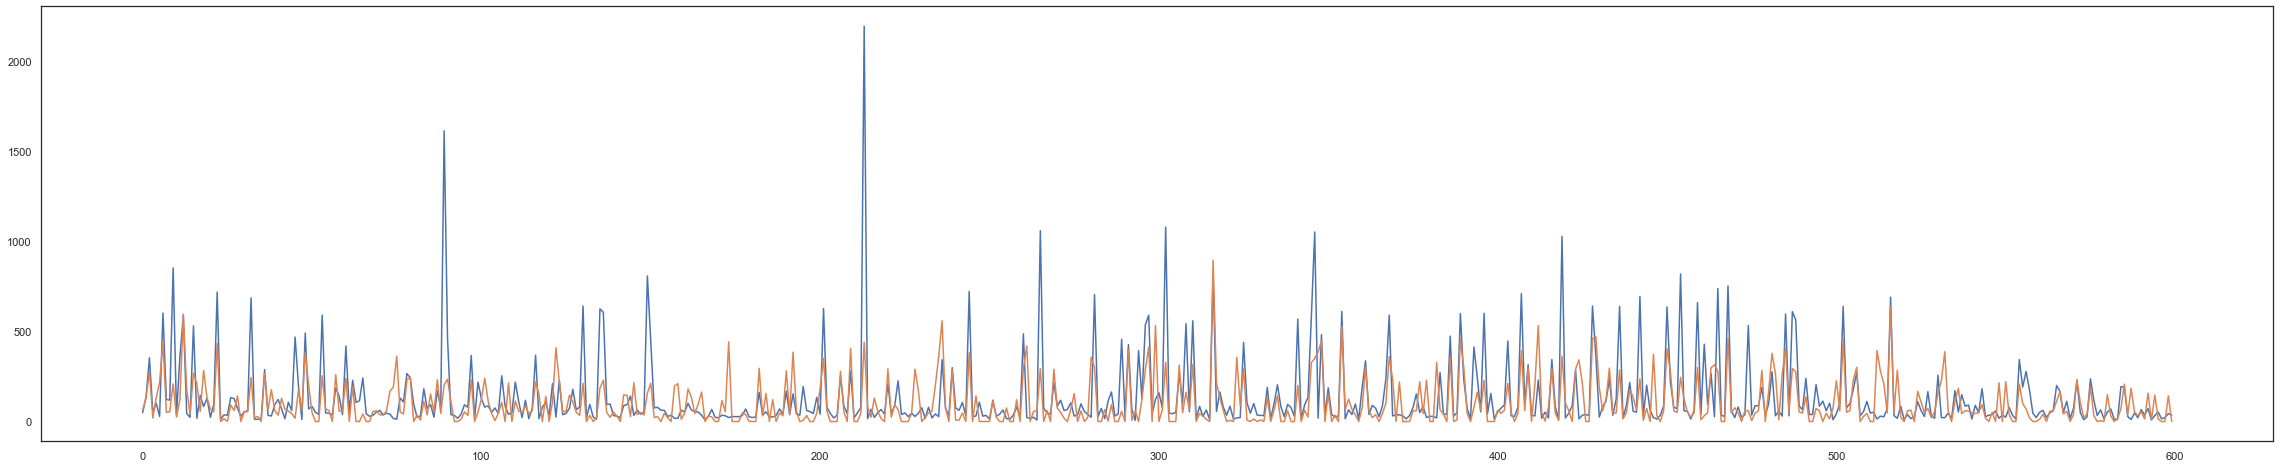

In [594]:
plt.figure(figsize=(40,8))
plt.plot(np.arange(y_test[1000:1600].shape[0]), y_test[1000:1600])
plt.plot(np.arange(y_test[1000:1600].shape[0]), y_pred[1000:1600])

In [595]:
import scipy
import random

In [596]:
error = (y_test - y_pred)
error.shape

(40089,)

In [597]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_error = scaler.fit_transform(error.reshape((-1,1)))

In [598]:
data_points = np.random.normal(0, 1, error.shape[0])

In [599]:
q_arr = np.arange(101)/100
th_quantiles = np.quantile(data_points,q_arr)
error_quantiles = np.quantile(scaled_error,q_arr)

<AxesSubplot:>

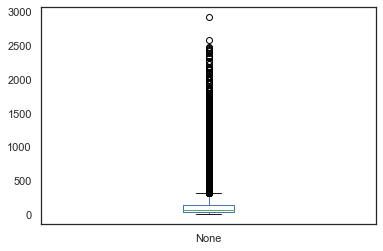

In [600]:
pd.Series(y_test).plot(kind='box')

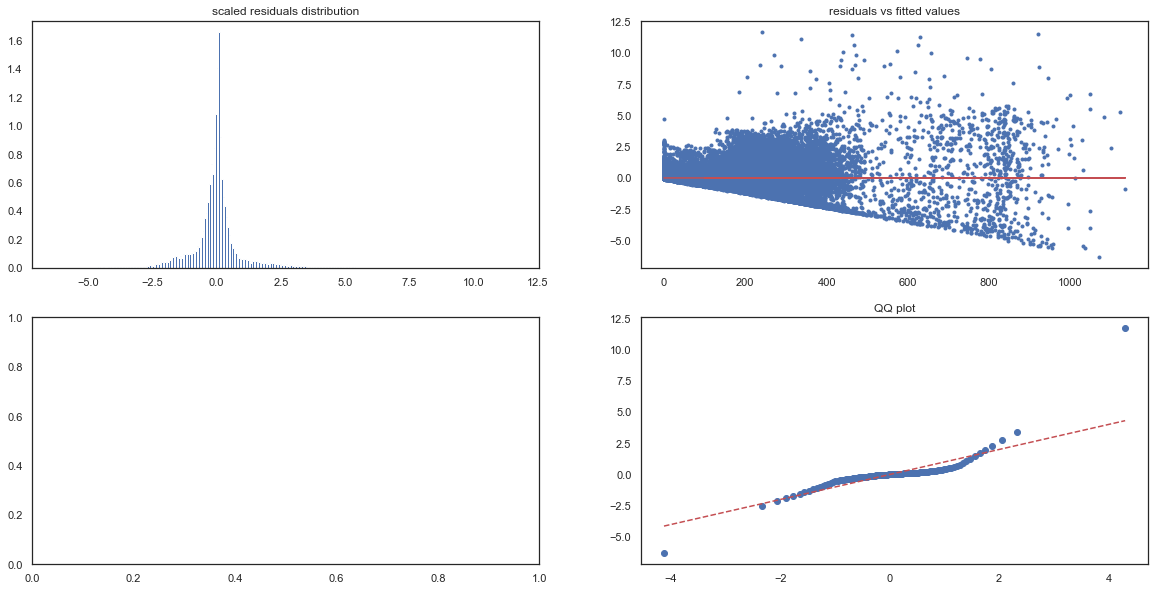

In [601]:
fig, axs = plt.subplots(2, 2, figsize = (20,10) )
axs[0,0].set_title('scaled residuals distribution')
_, bins, _ = axs[0,0].hist(scaled_error, bins=300, density = True)

axs[0,1].set_title('residuals vs fitted values')
axs[0,1].plot(y_pred, scaled_error, '.')
axs[0,1].plot(y_pred, np.zeros(y_pred.shape[0]), 'r-')

axs[1,1].set_title('QQ plot')
axs[1,1].plot(th_quantiles, error_quantiles, 'o')
axs[1,1].plot(th_quantiles, th_quantiles, 'r--')

plt.show()

In [602]:
#residuals doesn't follow normal distribution
scipy.stats.shapiro(scaled_error)

(0.8202707171440125, 0.0)

showing the histogram, we can intuitively make the hypothesis that the error distribution follows a normal distribtion <br>
If this hypothesis is correct, we can easily extract a prediction interval using the gaussian statistics table. <br>
Unfortenuatly, the shapiro test reject the null hypothesis. thus, we need first to estimate a kernel density for the error distribution, then we use the 5th and 95th kernel density percentiles to extract the prediction intervals. <br>
we can also use a straitforward emperical approach by extracting the 5th and 95th percentiles emperically from the error distrivution since we are in possession of a huge amount of data. or we can apply the bootstraping prediction interval approach using montecarlo simulation.

### interpretation : 

In [603]:
#export model
model.save_weights('./models/stoptime/stoptime.cpkt')